# Genetic contributions

The goal of this script is to reproduce the results of figure 2 from the article by Gauvin et al. (2015) \<[doi:10.1186/s12859-015-0581-5](https://doi.org/10.1186/s12859-015-0581-5)>.

In [1]:
!python --version

Python 3.10.12


Seaborn will be used for plotting. The GENEO toolkit will be used to load the datasets, identify the probands and their corresponding populations, and compute the founders' genetic contributions.

In [2]:
%pip install seaborn https://github.com/GPhMorin/geneo/archive/main.zip

  Using cached https://github.com/GPhMorin/geneo/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


The GENEO toolkit makes extensive use of Pandas dataframes, in this case, for probands' populations and for genetic contributions.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geneo as gen

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [4]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [5]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Probands are identified using the `gen.pro` function.

In [6]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [7]:
populations = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
set(populations)

{'Gaspesia-Acadian',
 'Gaspesia-FrenchCanadian',
 'Gaspesia-Loyalist',
 'Montreal',
 'NorthShore',
 'Quebec',
 'Saguenay'}

The original figure uses abbreviations for the populations, so let's do the conversion.

In [8]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

In [9]:
pops = [population_to_pop[population] for population in populations]
set(pops)

{'ACA', 'GFC', 'LOY', 'MON', 'NS', 'QUE', 'SAG'}

Let's assign a color to each population.

In [10]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

For each population, let's extract the subpedigree of their probands, compute the genetic contributions of their founders, then compute the cumulative genetic contribution in relationship with the cumulative proportion of founders.

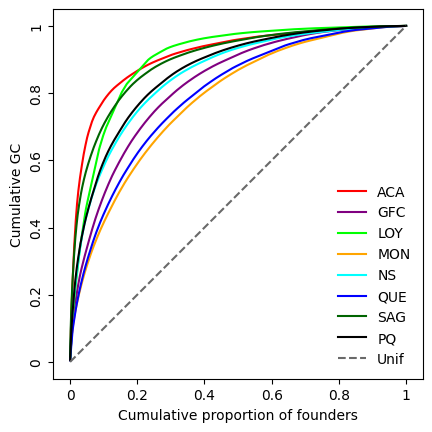

In [11]:
# For each population...
for pop in sorted(set(pops)):
    # ... identify the probands in the population
    inds = [ind for ind, p in zip(pro, pops) if p == pop]
    # ... extract the subpedigree of the probands
    ped = gen.branching(genea140, pro=inds)
    # ... compute the genetic contributions of their founders
    contributions = gen.gc(ped).sum(axis=0)
    # ... sort the contributions in descending order
    contributions.sort_values(ascending=False, inplace=True)
    # ... compute the cumulative genetic contributions
    contributions = contributions.cumsum() / contributions.sum()
    contributions.reset_index(drop=True, inplace=True)
    contributions.columns = ['Cumulative GC']
    contributions = contributions.to_frame(name='Cumulative GC')
    # ... compute the cumulative proportion of founders
    contributions['Cumulative proportion of founders'] = [(x + 1) / len(gen.founder(ped))
                                                      for x in range(len(gen.founder(ped)))]
    # ... plot
    ax = sns.lineplot(data=contributions, x='Cumulative proportion of founders',
                      y='Cumulative GC', color=pop_to_color[pop], label=pop)
# Do the same for the whole population
contributions = gen.gc(genea140).sum(axis=0)
contributions.sort_values(ascending=False, inplace=True)
contributions = contributions.cumsum() / contributions.sum()
contributions.reset_index(drop=True, inplace=True)
contributions.columns = ['Cumulative GC']
contributions = contributions.to_frame(name='Cumulative GC')
contributions['Cumulative proportion of founders'] = [(x + 1) / len(gen.founder(genea140))
                                                      for x in range(len(gen.founder(genea140)))]
ax = sns.lineplot(data=contributions, x='Cumulative proportion of founders',
                    y='Cumulative GC', color='black', label='PQ')
# Add a diagonal line that represents a uniform distribution
ax = sns.lineplot(x=[0, 1], y=[0, 1], color='dimgray', linestyle='--', label='Unif')
# Formatting options to make the plot more similar to the one in the paper
ax.set_aspect('equal')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _:'{:.0f}'.format(x)
                                               if round(x, 2) in [0.0, 1.0]
                                               else '{:.1f}'.format(x)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)
                                               if round(y, 2) in [0.0, 1.0]
                                               else '{:.1f}'.format(y)))
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
              [0, 0.2, 0.4, 0.6, 0.8, 1],
              va='center', rotation=90)
ax.legend(frameon=False)
plt.show()